In [ ]:
# pip install Dask ;
# pip install pysqlite ;
# pip install pandas ;
# pip install scikit-learn ;
# pip install group_lasso ;
# pip install numpy
# pip install asgl

# Mods

In [1]:
import numpy as np
import pandas as pd
import asgl
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

import sqlite3
import warnings
warnings.filterwarnings('ignore')

# OLS

In [2]:
df = pd.read_csv("/home/r00323024/Xwines.csv")


In [3]:
dfnew = df.groupby(['WineID', 'Vintage','Type',"Grapes","Country","Acidity",'ABV','Body' ])['Rating'].mean().reset_index()
dfnew = dfnew[dfnew["Vintage"] != "N.V."]
dfnew['Country_Vintage'] = df['Country'] + '_' + df['Vintage'].astype(str)

In [15]:
def abv_category(abv):
    if abv < 4:
        return '0-3.99%'
    elif abv < 8:
        return '4-7.99%'
    elif abv < 12:
        return '8-11.99%'
    elif abv < 16:
        return '12-15.99%'
    elif abv < 20:
        return '16-19.99%'
    else:
        return '20%以上'

# 将 ABV 值转换为对应的分类变量
dfnew['ABV'] = dfnew['ABV'].apply(abv_category)


In [4]:
dfnew

,WineID,Vintage,Type,Grapes,Country,Acidity,ABV,Body,Rating,Country_Vintage
0,100001,1988,Sparkling,['Muscat/Moscato'],Brazil,High,7.5,Medium-bodied,4.000000,Italy_1950
1,100001,1999,Sparkling,['Muscat/Moscato'],Brazil,High,7.5,Medium-bodied,4.500000,Italy_1950
2,100001,2007,Sparkling,['Muscat/Moscato'],Brazil,High,7.5,Medium-bodied,2.500000,Italy_1950
3,100001,2008,Sparkling,['Muscat/Moscato'],Brazil,High,7.5,Medium-bodied,3.630952,Italy_1950
4,100001,2009,Sparkling,['Muscat/Moscato'],Brazil,High,7.5,Medium-bodied,4.000000,Italy_1950
...,...,...,...,...,...,...,...,...,...,...
247299,200591,2018,Rosé,['Modrý Portugal'],Czech Republic,Medium,12.5,Medium-bodied,3.000000,France_1989
247300,200591,2020,Rosé,['Modrý Portugal'],Czech Republic,Medium,12.5,Medium-bodied,2.500000,France_1989
247301,200709,1989,Dessert,['Tamaioasa Romaneasca'],Romania,High,11.5,Medium-bodied,3.500000,France_1990
247302,200709,2008,Dessert,['Tamaioasa Romaneasca'],Romania,High,11.5,Medium-bodied,4.666667,France_1990


In [5]:
%load_ext sql
%sql sqlite://

In [6]:
conn = sqlite3.connect(':memory:')  # Use ':memory:' for in-memory database

# df.to_sql('my_table', conn, index=False, if_exists='replace')
dfnew.to_sql('table_new', conn, index=False, if_exists='replace')

246755

In [7]:

Rating = pd.read_sql_query("SELECT Rating FROM table_new;", conn)
Type = pd.read_sql_query("SELECT Type FROM table_new;", conn)
Grapes = pd.read_sql_query("SELECT Grapes FROM table_new;", conn)
Country = pd.read_sql_query("SELECT Country FROM table_new;", conn)
Vintage = pd.read_sql_query("SELECT Vintage FROM table_new;", conn)
Acidity = pd.read_sql_query("SELECT Acidity FROM table_new;", conn)
ABV = pd.read_sql_query("SELECT ABV FROM table_new;", conn)
Body = pd.read_sql_query("SELECT Body FROM table_new;", conn)
Country_Vintage = pd.read_sql_query("SELECT Country_Vintage FROM table_new;", conn)

In [8]:
Type_dum = pd.get_dummies(Type,drop_first=True, sparse=True).astype(int)
Grapes_dum = pd.get_dummies(Grapes,drop_first=True, sparse=True).astype(int)
Country_dum = pd.get_dummies(Country,drop_first=True, sparse=True).astype(int)
Vintage_dum = pd.get_dummies(Vintage,drop_first=True, sparse=True).astype(int)
Acidity_dum = pd.get_dummies(Acidity,drop_first=True, sparse=True).astype(int)
ABV_dum = pd.get_dummies(ABV,drop_first=True, sparse=True).astype(int)
Body_dum = pd.get_dummies(Body,drop_first=True, sparse=True).astype(int)
Country_Vintage_dum = pd.get_dummies(Country_Vintage,drop_first=True, sparse=True).astype(int)

In [9]:
final_df = pd.DataFrame(index=Type_dum.index)

dfs = [Type_dum, Grapes_dum, Country_dum, Vintage_dum,Acidity_dum,Body_dum,Country_Vintage_dum]
for i in dfs:
    final_df = pd.concat([final_df, i], axis=1)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246755 entries, 0 to 246754
Columns: 2119 entries, Type_Dessert/Port to Country_Vintage_United States_2021
dtypes: int64(2119)
memory usage: 3.9 GB


In [13]:
X = sm.add_constant(final_df)  # 添加截距项
y = Rating

model = sm.OLS(y, X)
results = model.fit()

In [18]:
def format_pvalues(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return ''


summary = results.summary()

tables = summary.tables[1].data  # 提取系数表（通常是第二个表）
headers = tables.pop(0)  
Result = pd.DataFrame(tables, columns=headers)

Result['P>|t|'] = Result['P>|t|'].astype(float).apply(lambda x: f"{x:.3f}" + format_pvalues(x))


In [19]:
file_path = "/home/r00323024/OLS.txt"
with open(file_path, "w") as f:
     f.write(Result.to_string())

# GL

In [24]:
lambda1 = (10.0 ** np.arange(-3, 1.51, 0.2)) # 23 possible values for lambda
alpha = np.arange(0, 1, 0.05) # 20 possible values for alpha

# Define model parameters
model = 'lm'  # linear model
penalization = 'sgl'  # sparse group lasso penalization
parallel = True  # Code executed in parallel
error_type = 'MSE'  # Error measuremente considered. MSE stands for Mean Squared Error.


In [41]:
Body_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246755 entries, 0 to 246754
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   Body_Light-bodied       246755 non-null  int64
 1   Body_Medium-bodied      246755 non-null  int64
 2   Body_Very full-bodied   246755 non-null  int64
 3   Body_Very light-bodied  246755 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


In [43]:
elements = [
    (1, 5),
    (2, 1535),
    (3, 37),
    (4, 71),
    (5, 2),
    (6, 4),
    (7, 5)
]

group_index = np.array([val for val, count in elements for _ in range(count)])

group_index

array([1, 1, 1, ..., 7, 7, 7])

In [44]:
# Define a cross validation object
cv_class = asgl.CV(model=model, penalization=penalization, lambda1=lambda1, alpha=alpha,
                   nfolds=5, error_type=error_type, parallel=parallel, random_state=99)
                   
# Compute error using k-fold cross validation
error = cv_class.cross_validation(x=final_df, y=Rating, group_index=group_index)

# Obtain the mean error across different folds
error = np.mean(error, axis=1)

# Select the minimum error
minimum_error_idx = np.argmin(error)

# Select the parameters associated to mininum error values
optimal_parameters = cv_class.retrieve_parameters_value(minimum_error_idx)
optimal_lambda = optimal_parameters.get('lambda1')
optimal_alpha = optimal_parameters.get('alpha')

InvalidIndexError: (array([133659, 222104,  79062, ..., 177337,  23587, 160385]), slice(None, None, None))

# RF

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# # 假设df是你的DataFrame
# # 如果 "Body" 和 "Acidity" 是分类变量，需要先将其编码成数值型
# le = LabelEncoder()
# df['Body'] = le.fit_transform(df['Body'])
# df['Acidity'] = le.fit_transform(df['Acidity'])

# # 确保 Rating 是目标变量，并且是连续变量
# X = df[['Body', 'Acidity']]  # 注意此处的写法，应该是双重方括号
# y = df['Rating']

# # 划分训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 初始化随机森林回归器，可以指定 n_estimators 和其他参数
# reg = RandomForestRegressor(n_estimators=100)  # 也可以修改其他参数
# reg.fit(X_train, y_train)

# # 使用reg.predict(X_test)来进行预测


# Stat

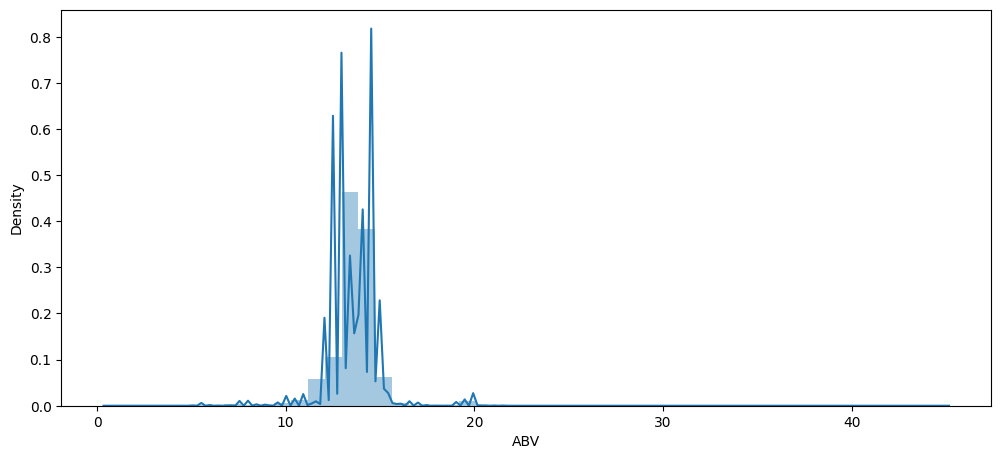

In [10]:

plt.figure(figsize=(12, 36)) 

plt.subplot(6, 1, 1)  
sns.distplot(df['ABV'])

# plt.subplot(6, 1, 2)  
# sns.histplot(df2['Body'], bins=len(df2['Body'].unique()))
# plt.xticks(rotation=45)

# plt.subplot(6, 1, 3)  
# sns.histplot(df2['Acidity'], bins=len(df2['Acidity'].unique()))

# plt.subplot(6, 1, 4)  
# sns.histplot(df2['Type'], bins=len(df2['Type'].unique()))

# plt.subplot(6, 1, 5)  # 6行1列的第5張圖
# sns.histplot(df2['Country'], bins=len(df2['Country'].unique()))
# plt.xticks(rotation=90)  # 旋轉標籤以避免重疊

# plt.subplot(6, 1, 6)  # 6行1列的第6張圖
# sns.histplot(df2['Elaborate'], bins=len(df2['Elaborate'].unique()))
# plt.xticks(rotation=45)

# plt.tight_layout()  # 調整子圖之間的間距
plt.show()


In [7]:
def count(column_name, dataframe):
    return len(dataframe[column_name].unique())

cols = ["Type", "Grapes", "Country", "Vintage","Acidity","Body","ABV"]

for i in cols:
    print(f"Number of unique values in {i}: {count(i, df)}")

Number of unique values in Type: 6
Number of unique values in Grapes: 1536
Number of unique values in Country: 38
Number of unique values in Vintage: 145
Number of unique values in Acidity: 3
Number of unique values in Body: 5
Number of unique values in ABV: 112


In [36]:
# unique_wines = df["WineName"].unique()
# file_path = "/home/r00323024/unique_wines.txt"
# with open(file_path, "w") as f:
#     for wine in unique_wines:
#         f.write(f"{wine}\n")

# Grapes = df["Grapes"].unique()
# file_path = "/home/r00323024/unique_Grapes.txt"
# with open(file_path, "w") as f:
#     for Grape in Grapes:
#         f.write(f"{Grape}\n")

Vintage = df["Vintage"].unique()
file_path = "/home/r00323024/unique_Vintage.txt"
with open(file_path, "w") as f:
    for i in Vintage:
        f.write(f"{i}\n")

In [7]:
grape_varieties = dfnew["Grapes"]

# We need to convert the strings back to lists and flatten them to count unique grapes
all_grapes = set()

for line in grape_varieties:
    # Convert the string list representation to an actual list
    variety_list = ast.literal_eval(line.strip())
    # Add each variety in the list to a set to ensure uniqueness
    for variety in variety_list:
        all_grapes.add(variety)

# Count of unique grape varieties
total_unique_grapes = len(all_grapes)
all_grapes, total_unique_grapes

file_path = "/home/r00323024/unique_Grape.txt"
with open(file_path, "w") as f:
    for i in all_grapes:
        f.write(f"{i}\n")

In [22]:

X = Grapes_dum
y = Type_dum["Type_White"]

model = sm.OLS(y, X).fit()

print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:             Type_White   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.856
Method:                 Least Squares   F-statistic:                              957.6
Date:                Fri, 19 Apr 2024   Prob (F-statistic):                        0.00
Time:                        14:48:22   Log-Likelihood:                      1.1869e+05
No. Observations:              246755   AIC:                                 -2.343e+05
Df Residuals:                  245220   BIC:                                 -2.183e+05
Df Model:                        1535                                                  
Covariance Type:            nonrobust                                                  
                                                                                                                        

In [16]:
from sklearn.cluster import AgglomerativeClustering
X = /home/r00323024/unique_Grape.txt . onehot
model = AgglomerativeClustering(n_clusters = n, linkage = 'ward')


,Type_Dessert/Port,Type_Red,Type_Rosé,Type_Sparkling,Type_White
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
246750,0,0,1,0,0
246751,0,0,1,0,0
246752,0,0,0,0,0
246753,0,0,0,0,0
